本实验采用多个LSTM层搭建一个深度LSTM网络，使用10天的股价数据，预测第11天的股价

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [23]:
df = yf.download('1024.HK',period='5y',interval='1d') ##kuaishou
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-05,338.000000,345.000000,300.000000,300.000000,300.000000,119899748
2021-02-08,301.799988,310.000000,283.000000,303.000000,303.000000,28700114
2021-02-09,309.000000,352.000000,308.000000,350.600006,350.600006,38036864
2021-02-10,366.799988,398.000000,365.000000,397.000000,397.000000,25460855
2021-02-11,399.200012,399.200012,399.200012,399.200012,399.200012,0
...,...,...,...,...,...,...
2023-08-03,65.550003,67.949997,65.250000,67.000000,67.000000,18358220
2023-08-04,69.099998,71.199997,67.599998,68.849998,68.849998,24430606
2023-08-07,68.550003,68.800003,67.400002,68.550003,68.550003,10816743


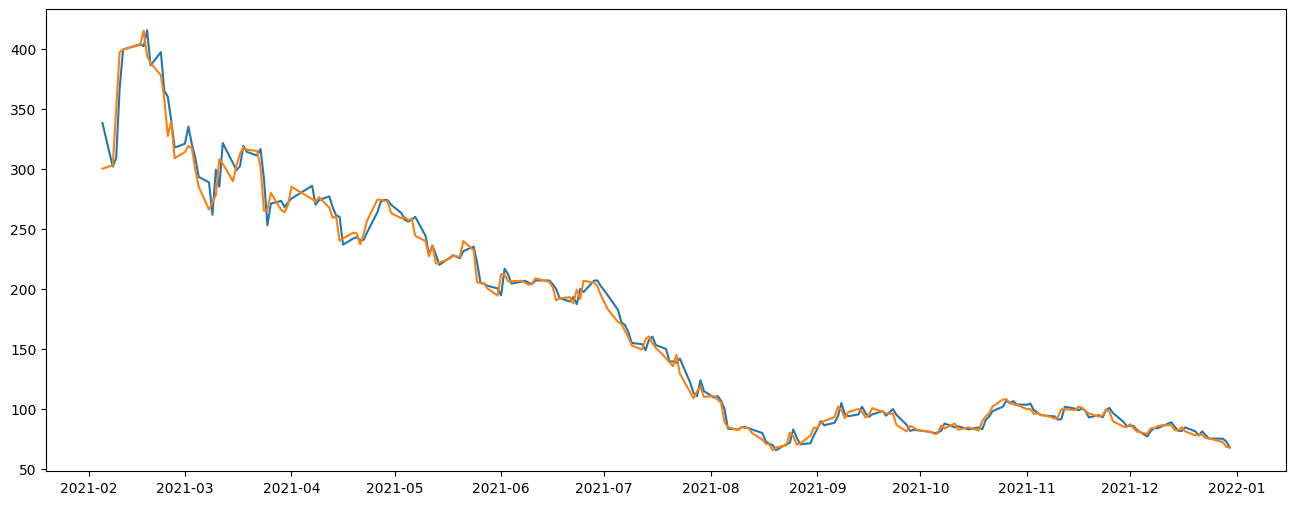

In [35]:
#打印出21年的股票价格
plt.figure(figsize=(16,6))
plt.plot(df.loc[:"2021-12-30",['Open','Close']])

数据归一化

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df = df['Close']
rdata = scaler.fit_transform(np.array(df).reshape(-1,1))

In [6]:
training_size = int(len(rdata)*0.7)
train_data,test_data = rdata[:training_size,:],rdata[training_size:,:]

使用keras做时间序列数据

In [ ]:
! pip install keras

In [14]:
#这部分其实就是将X，y进行匹配，长度为十，即用10天的数据，预测第11天
from keras.preprocessing.sequence import TimeseriesGenerator
train = TimeseriesGenerator(train_data,train_data,length=10,batch_size=len(rdata))
test = TimeseriesGenerator(test_data,test_data,length=10,batch_size=len(rdata))
X_train,y_train = list(train)[0][0],list(train)[0][1]
X_test,y_test = list(test)[0][0],list(test)[0][1]

In [ ]:
#打印X和y
for i in range(len(X_train)):
  print(X_train[i]," => ",y_train[i])

使用TensorFlow作为深度学习框架

In [ ]:
! pip install tensorflow

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [17]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

In [20]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

6/6 [==============================] - 0s 9ms/step


画出原数据，训练集预测，测试集预测数据

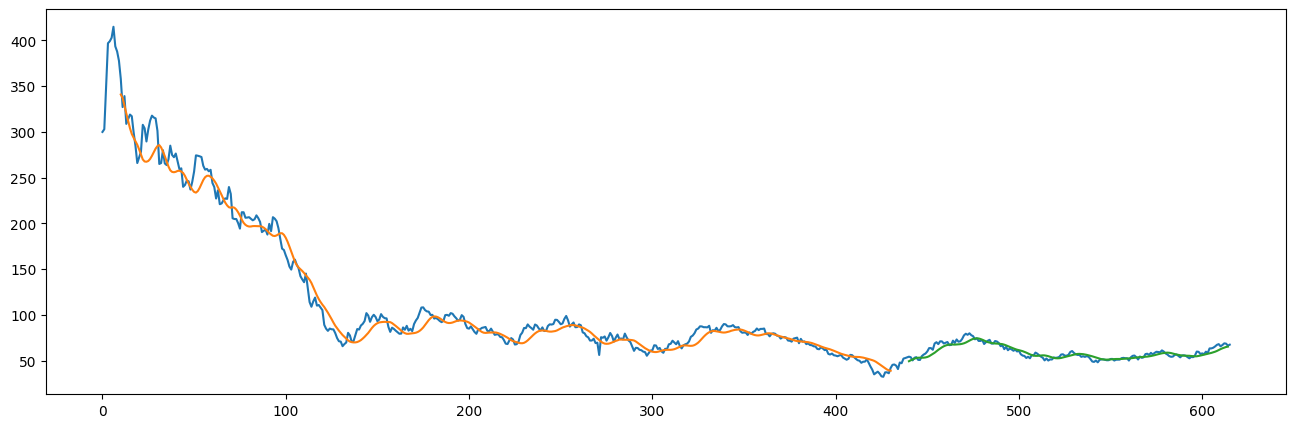

In [21]:
look_back = 10
trainPredictPlot=np.empty_like(rdata)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict

testPredictPlot=np.empty_like(rdata)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)-1:len(rdata)-1,:]=test_predict

plt.figure(figsize=(16,5))
plt.plot(scaler.inverse_transform(rdata))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
